# Delta-X 2022 Applications Workshop

# Comparing AirSWOT to In Situ Data

© 2022 California Institute of Technology. Government sponsorship acknowledged.

Author: Michael Denbina, Jet Propulsion Laboratory, California Institute of Technology

---

The AirSWOT tutorial is split into three modules, which cover:

1. AirSWOT Data Introduction
2. Estimating Water Surface Elevation and Slope from AirSWOT 
3. Comparing AirSWOT to In Situ Data (this module)

In this module, we will show examples comparing water surface elevations from AirSWOT to in situ data.  We will also show how AirSWOT can be used to estimate the vertical datum offset for in situ data with an unknown datum.  We will also discuss how to convert between the WGS84 and NAVD88 vertical datums.

We will begin by importing a number of modules that we need, and then pointing to the location where the data has been downloaded, similar to the first module.

**Note**: As in the previous module, you may need to update the variable "data_path" and data filenames to point to where the data is located if you have moved the data or downloaded it separately rather than using the sample data included with this tutorial.

In [ ]:
# Setup Google Colab:
# If you aren't using Google Colab -- skip running this cell.

# For access to Google Drive files
from google.colab import files
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# For saving to Google Drive
from google.colab import drive
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
Gdrive = GoogleDrive(gauth)

drive.mount('/content/drive',force_remount=True)

In [1]:
# Data path pointing to AirSWOT sample data and associated files:
data_path = '/content/drive/MyDrive/DeltaX_Workshop_2022/Tutorials/2_AirSWOT'
data_path = 'airswot_sample_data'

# By default, this is pointing to the location of the data on your Google Drive
# (assuming you added a shortcut to the workshop materials).

# If you are running on your local machine, update data_path to the location where you
# saved the files.

In [2]:
# This module also needs to save some output files!  Please change the path below to
# a folder where it is OK to write some GeoTIFF files.
save_data_path = '/content/drive/MyDrive/DeltaX_Workshop_2022/Tutorials/2_AirSWOT/L2'

# The default path is relative to the location of this notebook.

In [3]:
# Import Useful Libraries
from datetime import datetime, timedelta # for handling dates and times of station and AirSWOT data
import os
import numpy as np
from osgeo import gdal
import matplotlib.pyplot as plt
import pandas as pd

# Filenames of the data we will use in this module, relative to data_path.
crms_station_data_file = os.path.join(data_path, 'station_data/CRMS0434-H01_20060217180000-20210929090000_downloaded20211206.csv')
calumet_station_data_file = os.path.join(data_path, 'station_data/USGS_Calumet_wl.csv')

# AirSWOT Data (copy/pasted from our results in the previous module):
airswot_wse = np.array([-25.504597, -25.560078, -25.446281, -25.34314])
airswot_datetime = np.array([datetime(2021, 4, 16, 0, 54, 32),
                             datetime(2021, 4, 16, 4, 17, 20),
                             datetime(2021, 4, 18, 16, 43, 12),
                             datetime(2021, 4, 18, 20, 20, 23)])

hgt_raster_files = np.array(['L2/utm_m0m_20210326171437.hgt.tif',
                             'L2/utm_m0m_20210326194454.hgt.tif',
                             'L2/utm_m0m_20210327142430.hgt.tif',
                             'L2/utm_m0m_20210327164503.hgt.tif',
                             'L2/utm_m0m_20210401124406.hgt.tif',
                             'L2/utm_m0m_20210401152540.hgt.tif'])

We will load the CRMS data into a DataFrame using Pandas.  We will then convert the date and time from the CSV file, which are text strings, into Python datetime objects so that they will be easier to compare with the AirSWOT data.

In [4]:
# Load the CRMS data into Pandas.
crms = pd.read_csv(crms_station_data_file)

# Print the CRMS DataFrame:
print(crms)

# Print the columns (field names) of the DataFrame:
print(crms.columns)

# Conversion factor from feet to meters.  (CRMS station water levels are in feet.)
feet_to_meters = 0.3048

# Load the height from the CRMS data and convert it to meters.
crms_hgt = np.array(crms['Raw Water Level (ft)']) * feet_to_meters

# Load the dates and times.
dates = np.array(crms['Date (mm/dd/yyyy)'])
times = np.array(crms['Time (hh:mm:ss)'])

# Track the number of CRMS data records and create an array to store the dates and times as integers.
num_of_records = len(dates)
datetime_int = np.zeros((num_of_records, 5), dtype='int')

# Loop through the dates and times, converting each part (e.g. year, month, day, hour, minute) into an integer.
for num, (date_str, time_str) in enumerate(zip(dates, times)):
    date_str = date_str.split('/')
    datetime_int[num, 0] = int(date_str[2])
    datetime_int[num, 1] = int(date_str[0])
    datetime_int[num, 2] = int(date_str[1])
    
    time_str = time_str.split(':')
    datetime_int[num, 3] = int(time_str[0])
    datetime_int[num, 4] = int(time_str[1])


# The CRMS data is in Central time, while the AirSWOT data is in UTC.
# We must therefore either shift the CRMS data forward by five hours, or the AirSWOT data back.
# We will shift the CRMS data forward:
time_shift = timedelta(hours=5)

# Convert the dates and times to Python datetime objects.
crms_datetime = np.empty((num_of_records), dtype=datetime)
for num in range(datetime_int.shape[0]):
    crms_datetime[num] = datetime(datetime_int[num, 0], datetime_int[num, 1], datetime_int[num, 2], datetime_int[num, 3], datetime_int[num, 4], 0) + time_shift

# We do not care about all of the CRMS data in the file.
# Let us only consider the period of five days around the time of the AirSWOT acquisition.
start_datetime = datetime(2021, 4, 15, 0, 0, 0)
end_datetime = datetime(2021, 4, 20, 0, 0, 0)
date_range = (crms_datetime < end_datetime) & (crms_datetime > start_datetime)

# Subset the CRMS data to the desired date range.
crms_datetime = crms_datetime[date_range]
crms_hgt = crms_hgt[date_range]

/var/folders/4w/7rkh8_zj75d9qv3zk6kvbqrc0000gr/T/ipykernel_26280/3685075272.py:2: DtypeWarning: Columns (46) have mixed types. Specify dtype option on import or set low_memory=False.
  crms = pd.read_csv(crms_station_data_file)


        Unnamed: 0.2  Unnamed: 0  Unnamed: 0.1    Station ID  \
0                  0           0             0  CRMS0434-H01   
1                  1           1             1  CRMS0434-H01   
2                  2           2             2  CRMS0434-H01   
3                  3           3             3  CRMS0434-H01   
4                  4           4             4  CRMS0434-H01   
...              ...         ...           ...           ...   
136859        136859      136859        136859  CRMS0434-H01   
136860        136860      136860        136860  CRMS0434-H01   
136861        136861      136861        136861  CRMS0434-H01   
136862        136862      136862        136862  CRMS0434-H01   
136863        136863      136863        136863  CRMS0434-H01   

       Date (mm/dd/yyyy) Time (hh:mm:ss) Time Zone Sensor Environment  \
0              2/17/2006        18:00:00       CST      Surface Water   
1              2/17/2006        19:00:00       CST      Surface Water   
2           

Let's plot the CRMS and AirSWOT data on the same plot, to compare their water surface elevation values:

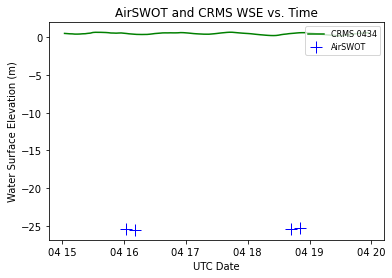

In [5]:
# Plot the CRMS time series and AirSWOT data.
plt.figure()
plt.plot(crms_datetime, crms_hgt, 'g-', label='CRMS 0434')
plt.plot(airswot_datetime, airswot_wse, 'b+', markersize=12, label='AirSWOT')
import matplotlib.dates as mdates
myFmt = mdates.DateFormatter('%m %d')
plt.gca().xaxis.set_major_formatter(myFmt)
plt.title('AirSWOT and CRMS WSE vs. Time')
plt.legend(loc='upper right', frameon=True, fontsize=8)
xlbl = plt.xlabel('UTC Date')
ylbl = plt.ylabel('Water Surface Elevation (m)')

There is a very large difference between the water levels reported by CRMS and AirSWOT!  But why?

Actually, this is expected, because the AirSWOT data and the CRMS data are in different vertical datums.  That is, their elevations are referenced to different surfaces.

The AirSWOT data is with respect to the WGS84 ellipsoid, while the CRMS data that we loaded is raw gauge data and therefore records elevations relative to the position of the water level gauge, rather than to a geoid or ellipsoid surface.

One of the useful applications of AirSWOT is that we can estimate the datum of a gauge by calculating the difference between AirSWOT and gauge data.  We will do this now, estimating the vertical datum of the CRMS station using AirSWOT, and then comparing that to the height of the NAVD88 geoid at the station location, to see if our conversion factor is reasonable.

In [6]:
# This helpful function will interpolate the CRMS station data to the same time as the AirSWOT data.
def interpolate_station_wl(station_datetime, station_wl, interpolated_utc):
    """ Interpolate the given station water level timeseries to the desired UTC datetime. """
    # Convert datetimes in station data to time after first record:
    wl_series = np.array(station_wl, dtype='float32')
    datetime_series = np.array(station_datetime, dtype=datetime)
    timedelta_series = (datetime_series - datetime_series[0]).astype(timedelta)
    timedelta_series = np.ravel(timedelta_series)

    interpolated_timedelta = interpolated_utc - station_datetime[0]

    # Convert timedeltas to floating point seconds.
    timedelta_series /= timedelta(seconds=1)
    timedelta_series = timedelta_series.astype('int64')
    interpolated_timedelta /= timedelta(seconds=1)
    

    # Interpolate water levels at requested datetime.
    interpolated_wl = np.interp(interpolated_timedelta, timedelta_series, wl_series)
    return interpolated_wl


# Interpolate the station water levels at the AirSWOT acquisition times:
wse_difference = np.zeros((4), dtype='float32')
for num, dt in enumerate(airswot_datetime):
    station_wse_interpolated_to_airswot = interpolate_station_wl(crms_datetime, crms_hgt, dt)
    wse_difference[num] = airswot_wse[num] - station_wse_interpolated_to_airswot

print('AirSWOT - CRMS Water Level Differences:')
print(wse_difference)
print('')
print('Median AirSWOT - CRMS Water Level Difference: {:.2f} m'.format(np.median(wse_difference)))
print('Std. Dev. of AirSWOT - CRMS Water Level Differences: {:.2f} m'.format(np.std(wse_difference)))

AirSWOT - CRMS Water Level Differences:
[-26.034956 -25.982801 -25.971148 -25.969074]

Median AirSWOT - CRMS Water Level Difference: -25.98 m
Std. Dev. of AirSWOT - CRMS Water Level Differences: 0.03 m


According to this estimate, to convert the station data to have the same vertical datum as AirSWOT (the WGS84 ellipsoid), we need to subtract 25.98 m from the CRMS station data.  Let's do that now and look at the updated plot:

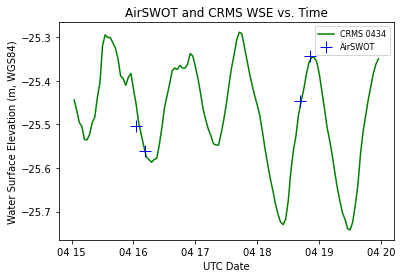

In [7]:
plt.figure()
plt.plot(crms_datetime, crms_hgt - 25.98, 'g-', label='CRMS 0434')
plt.plot(airswot_datetime, airswot_wse, 'b+', markersize=12, label='AirSWOT')
import matplotlib.dates as mdates
myFmt = mdates.DateFormatter('%m %d')
plt.gca().xaxis.set_major_formatter(myFmt)
plt.title('AirSWOT and CRMS WSE vs. Time')
plt.legend(loc=0, frameon=True, fontsize=8)
xlbl = plt.xlabel('UTC Date')
ylbl = plt.ylabel('Water Surface Elevation (m, WGS84)')

When doing this procedure, if the AirSWOT elevations are incorrect, then of course we will get the wrong datum adjustment.  But we can be more confident in the AirSWOT estimates when the difference between AirSWOT and the station data is consistent over time between different flights and flight lines, such as in the above.  Even if the absolute WSE calibration is off by a few cm, AirSWOT and the CRMS station data both record the same change in water level between the times of the AirSWOT acquisitions.

Remember that I said we were using the raw gauge data from the CRMS station, not referenced to a datum?  While that is true in general, for this particular station, it so happens that the raw gauge elevation data is very close to the NAVD88 geoid.

One way to convert between vertical datums easily is to use the NOAA tool vDatum, which can be found at the following website: [NOAA VDatum](https://vdatum.noaa.gov/).

There is both a downloadable tool, as well as an online tool.  For the sake of convenience, we'll use the online tool in this application, which can be found here: [NOAA VDatum Online Conversion](https://vdatum.noaa.gov/vdatumweb/).

To calculate the difference in vertical datum between the WGS84 ellipsoid and the NAVD88 geoid, we need to know the location of the station.  This data is included in the CRMS data:

In [8]:
latitude = crms['Latitude'][0]
longitude = crms['Longitude'][0]
print('CRMS Latitude: {}'.format(latitude))
print('CRMS Longitude: {}'.format(longitude))

CRMS Latitude: 29.32038939
CRMS Longitude: -90.73313434


Now let's use this latitude and longitude to calculate the difference between the WGS84 and NAVD88 vertical datums:

![NOAA VDatum Step One](images/noaa_vdatum_step1.png)

When you click the "Transform" button, you will be prompted to specify the input and output dates.  This is because the transformation between the datums varies not only spatially but also over time.  In truth, we don't really know when the input position for the station data was surveyed, but we'll put "2021.0" for both the input and output dates:

![NOAA VDatum Step One](images/noaa_vdatum_step2.png)

Note that there is a small change in the output position, not just the output height.  However, this change in horizontal position will tend to be small when converting between WGS84 and NAD83/NAVD88.  This change in horizontal position can be ignored in this case, as it will be less than the spatial resolution of the AirSWOT data.

However, the change in vertical height is substantial, and must be considered.  In this case, VDatum reports that the height difference from WGS84 to NAVD88 is 25.948 m.

This is very close to the 25.98 m we calculated from AirSWOT.  These are within a few cm, so are within the expected error level of AirSWOT.  There are other reasons that can explain these small differences as well, such as the fact that we calculated the water surface elevation centered around the lake, but the CRMS station is actually located in a side channel near the lake.  Since the water is connected, they should be at a similar height, but a small difference in water level between the lake and the channel is possible.

Finally, let's plot the water levels again, this time using the conversion factor from VDatum.  In this case, we aill add the conversion factor to the AirSWOT water levels, so that the plot this time will be with respect to the NAVD88 geoid rather than the WGS84 ellipsoid:

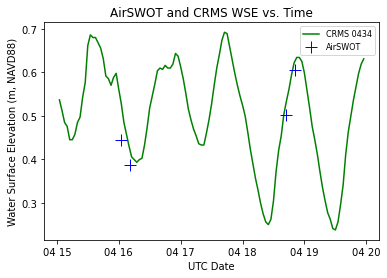

In [9]:
plt.figure()
plt.plot(crms_datetime, crms_hgt, 'g-', label='CRMS 0434')
plt.plot(airswot_datetime, airswot_wse + 25.948, 'b+', markersize=12, label='AirSWOT')
import matplotlib.dates as mdates
myFmt = mdates.DateFormatter('%m %d')
plt.gca().xaxis.set_major_formatter(myFmt)
plt.title('AirSWOT and CRMS WSE vs. Time')
plt.legend(loc=0, frameon=True, fontsize=8)
xlbl = plt.xlabel('UTC Date')
ylbl = plt.ylabel('Water Surface Elevation (m, NAVD88)')

## Converting the Vertical Datum of AirSWOT L2 Products

So far, we have demonstrated how to convert the vertical datum of a single point such as a water level station.  However, what if we want to convert an entire L2 AirSWOT product from WGS84 to the NAVD88 vertical datum.

We can do this using GDAL, as illustrated in the following example.  This time, we will go back to the Atchafalaya Basin, to the same flight line we used in the first module, to demonstrate the conversion.

**Note**: After testing this notebook on Google Colab, the below code example had errors.  It should work if you run it on your local machine with GDAL installed, however, for the purposes of this tutorial, I have provided a different way to convert the vertical datum of the AirSWOT data.  If you wish to use the original method, set the "use_gdal" variable in the below code to True.  By default, it will be False.

If you have errors running the below example, one reason can be that your GDAL installation cannot find the geoid grid file "g2012bu0.gtx" specified below.  In that case, you can download geoid GTX files from the following link: [NAVD88 GEOID12B](http://download.osgeo.org/proj/vdatum/usa_geoid2012b.zip)

In [10]:
use_gdal = False

# NOTE: The below code doesn't seem to work correctly on Google Colab.
# It will produce height rasters which are all zero.
# However, instead of using GDAL to perform the vertical datum transformation,
# we can also interpolate the value of the geoid for each pixel and adjust the height
# of the AirSWOT data that way.

# Create the save_data_path folder, if it does not already exist.
if use_gdal:
    if not os.path.exists(save_data_path):
        os.makedirs(save_data_path)

    warp_options = gdal.WarpOptions(format='GTiff',
                                    srcSRS='+proj=utm +zone=15 +datum=WGS84 +units=m +no_defs',
                                    dstSRS='+proj=utm +zone=15 +datum=WGS84 +units=m +no_defs +geoidgrids=g2012bu0.gtx')

    for hgt_file_wgs84 in hgt_raster_files:
        print('Converting vertical datum of file "{}"...'.format(hgt_file_wgs84))
        hgt_file_navd = os.path.basename(hgt_file_wgs84).split('.')[0] + '.hgt_navd.tif'
        hgt_file_navd = os.path.join(save_data_path, hgt_file_navd)
        navd_hgt = gdal.Warp(hgt_file_navd, os.path.join(data_path, hgt_file_wgs84), options=warp_options)

If you ran the above code, it should have generated files with names ending in ".hgt_navd.tif" in addition to the original ".hgt.tif" files.  If you load these ".hgt_navd.tif" files in QGIS, you should see that the elevation values are closer to zero now that they are referenced to the geoid rather than to the WGS84 ellipsoid.

Most of you, however, probably did **not** run the code above, in which case, we will subtract the height of the geoid from the AirSWOT heights when calculating the water surface elevations, below.

We will now reuse code from the previous module in order to derive AirSWOT water surface elevation estimates near the USGS Calumet water level station, which is located in the Wax Lake Outlet, upstream of the Intracoastal Waterway.  The USGS Calumet station data included in the sample data for this tutorial was downloaded [here](https://waterdata.usgs.gov/nwis/uv?site_no=07381590).

At 2021-03-26 17:14:37, the AirSWOT WSE at Calumet was 1.55 m with respect to the NAVD88 geoid.
At 2021-03-26 19:44:54, the AirSWOT WSE at Calumet was 1.58 m with respect to the NAVD88 geoid.
At 2021-03-27 14:24:30, the AirSWOT WSE at Calumet was 1.57 m with respect to the NAVD88 geoid.
At 2021-03-27 16:45:03, the AirSWOT WSE at Calumet was 1.57 m with respect to the NAVD88 geoid.
At 2021-04-01 12:44:06, the AirSWOT WSE at Calumet was 1.56 m with respect to the NAVD88 geoid.
At 2021-04-01 15:25:40, the AirSWOT WSE at Calumet was 1.56 m with respect to the NAVD88 geoid.


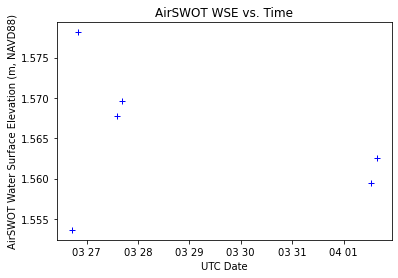

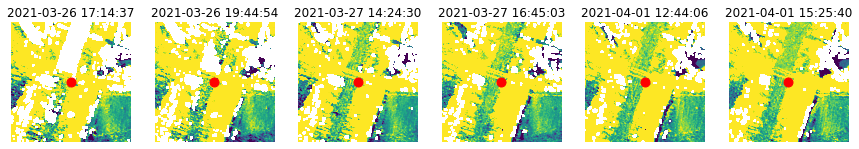

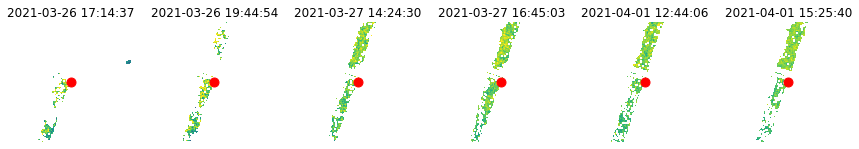

In [11]:
# I got the latitude and longitude position of the Calumet station from the above link,
# then converted it to UTM coordinates using VDatum.
x_calumet = 657426.03200 # X coordinate position of the USGS Calumet station, in UTM Zone 15 North.
y_calumet = 3286405.15100 # Y coordinate position of the USGS Calumet station.

if use_gdal:
    hgt_raster_files_navd = np.array(['utm_m0m_20210326171437.hgt_navd.tif',
                                      'utm_m0m_20210326194454.hgt_navd.tif',
                                      'utm_m0m_20210327142430.hgt_navd.tif',
                                      'utm_m0m_20210327164503.hgt_navd.tif',
                                      'utm_m0m_20210401124406.hgt_navd.tif',
                                      'utm_m0m_20210401152540.hgt_navd.tif'])
else:
    hgt_raster_files_navd = hgt_raster_files


# Helper functions from the previous module.
def nearest_interpolate(data, x, y, nodataval=np.nan):
    """Function to perform nearest neighbor interpolation on the input array
        data, at the image coordinates given by input arguments x and y.

    Arguments
        data (array): 2D array containing raster data to interpolate.
        x (array): the X coordinate values at which to interpolate (in array
            indices, starting at zero).  Note that X refers to the second
            dimension of data (e.g., the columns).
        y (array): the Y coordinate values at which to interpolate (in array
            indices, starting at zero).  Note that Y refers to the first
            dimension of data (e.g., the rows).
        nodataval: No data value for points outside of the data bounds.

    Returns:
        intdata (array): The 2D interpolated array, with same dimensions as
            x and y.

    """
    x = np.asarray(x)
    y = np.asarray(y)

    x = np.round(x).astype('int32')
    y = np.round(y).astype('int32')

    ind = (x < 0) | (y < 0) | (x >= data.shape[1]) | (y >= data.shape[0])

    if np.any(ind):
        x[ind] = 0
        y[ind] = 0

    intdata = (data[y, x]).astype('float32')

    if np.any(ind):
        intdata[ind] = nodataval

    return intdata


def interp_raster_at_xy(data, geo_transform, x, y):
    """ Interpolate values of raster at input coordinates using nearest
        neighbor interpolation. """
    # Calculate the image coordinates from the given map coordinates:
    rows, columns = calculate_image_coords(x, y, geo_transform)
    
    # Calculate the mask value at the given coordinates using nearest neighbor interpolation:
    ds_interp = nearest_interpolate(data, columns, rows)
    return ds_interp


def get_coords_of_image_chip(geo_transform, rows, cols):
    """ Calculate the map coordinates for a given image chip using
        the geo_transform and image coordinates of that chip. """
    x_coords = cols*geo_transform[1] + geo_transform[0]
    y_coords = rows*geo_transform[5] + geo_transform[3]
    return x_coords, y_coords


def calculate_image_coords(x_coord, y_coord, geo_transform):
    x_origin = geo_transform[0]
    y_origin = geo_transform[3]
    x_spacing = geo_transform[1]
    y_spacing = geo_transform[5]
    
    row = (y_coord - y_origin) / y_spacing
    column = (x_coord - x_origin) / x_spacing
    
    return row, column


def filter_points_mad(z, thresh=2):
    # Remove height outliers.
    if np.any(np.isfinite(z)):
        med = np.nanmedian(z)
        abs_dev = np.abs(z - med)
        left_mad = np.nanmedian(abs_dev[z <= med])
        right_mad = np.nanmedian(abs_dev[z >= med])

        z_mad = left_mad * np.ones(z.shape)
        z_mad[z > med] = right_mad

        h_score = 0.6745 * abs_dev / z_mad
        h_score[z == med] = 0

        ind = (h_score <= thresh) & np.isfinite(z)
    else:
        ind = np.isfinite(z)

    return ind


# Load the water mask.
water_mask_file = os.path.join(data_path, 'water_mask/Sentinel2_DOS_mosaic_sub_EVI_mask.tif')
water_mask = gdal.Open(water_mask_file)
water_mask_data = water_mask.ReadAsArray()
water_mask_geo = water_mask.GetGeoTransform()

# Load the NAVD88 geoid raster.
if not use_gdal:
    geoid_file = os.path.join(data_path, 'navd88_geoid12b_utm.tif')
    geoid = gdal.Open(geoid_file)
    geoid_data = geoid.ReadAsArray()
    geoid_geo = geoid.GetGeoTransform()

# Empty arrays to store the WSE and datetimes.
airswot_wse = np.array([], dtype='float32')
airswot_datetime = np.array([], dtype=datetime)
airswot_hgt_stack = None
airswot_hgt_stack_masked_filtered = None

# Loop through the AirSWOT L2 rasters, calculating the water surface elevation of the lake for each raster.
for file in hgt_raster_files_navd:
    if use_gdal:
        hgt_product = gdal.Open(os.path.join(save_data_path, file))
    else:
        hgt_product = gdal.Open(os.path.join(data_path, file))
    
    hgt_product_data = hgt_product.ReadAsArray()
    hgt_product_data[hgt_product_data == -10000] = np.nan # Values of -10000 represent void data.
    hgt_product_geo = hgt_product.GetGeoTransform()
    
    # Calculate the AirSWOT image coordinates corresponding to the lake:
    row_station, column_station = calculate_image_coords(x_calumet, y_calumet, hgt_product_geo)
    
    # Subset the AirSWOT data to an image chip containing the USGS Calumet station and surrounding area:
    row_station_int = int(row_station)
    column_station_int = int(column_station)
    hgt_station_chip = hgt_product_data[row_station_int-200:row_station_int+201,
                                        column_station_int-200:column_station_int+201]

    # Calculate the row and column image coordinates for each pixel in the AirSWOT image chip.
    rows_station_chip = np.arange(row_station_int-200, row_station_int+201)
    columns_station_chip = np.arange(column_station_int-200, column_station_int+201)
    rows_station_chip = np.tile(rows_station_chip, (len(columns_station_chip), 1)).T
    columns_station_chip = np.tile(columns_station_chip, (len(rows_station_chip), 1))
    
    # Calculate the X and Y UTM coordinates for each pixel in the AirSWOT image chip.
    x_station_chip, y_station_chip = get_coords_of_image_chip(hgt_product_geo, rows_station_chip, columns_station_chip)

    # Interpolate the value of the water mask at the desired coordinates:
    water_mask_lake_chip = interp_raster_at_xy(water_mask_data, water_mask_geo, x_station_chip, y_station_chip)
    water_mask_lake_chip = water_mask_lake_chip > 0
    
    # If not using GDAL to perform the vertical datum transformation...
    # Interpolate the value of the NAVD88 geoid at the desired coordinates:
    if not use_gdal:
        geoid_lake_chip = interp_raster_at_xy(geoid_data, geoid_geo, x_station_chip, y_station_chip)
        hgt_station_chip -= geoid_lake_chip
    
    # Mask the AirSWOT height data:
    hgt_station_chip_masked = hgt_station_chip.copy()
    hgt_station_chip_masked[~water_mask_lake_chip] = np.nan

    # Apply the outlier filter:
    indices_to_keep = filter_points_mad(hgt_station_chip_masked)
    hgt_station_chip_masked_filtered = hgt_station_chip_masked.copy()
    hgt_station_chip_masked_filtered[~indices_to_keep] = np.nan
    
    # Calculate the water surface elevation as the mean height in the masked water data.
    # Only calculate the WSE if at least 100 pixels containing height data are in the window.
    if np.sum(np.isfinite(hgt_station_chip_masked_filtered)) > 100:
        temp_wse = np.nanmean(hgt_station_chip_masked_filtered)
    else:
        temp_wse = np.nan
    
    # Let's also parse the AirSWOT product filename to a datetime:
    datetime_string = file.split('_')[2].split('.')[0]
    year = int(datetime_string[0:4])
    month = int(datetime_string[4:6])
    day = int(datetime_string[6:8])
    hour = int(datetime_string[8:10])
    minute = int(datetime_string[10:12])
    second = int(datetime_string[12:14])
    
    temp_datetime = datetime(year=year, month=month, day=day, hour=hour, minute=minute, second=second)
    
    # Append the values for this flight line to the arrays:
    airswot_wse = np.append(airswot_wse, temp_wse)
    airswot_datetime = np.append(airswot_datetime, temp_datetime)
    
    if airswot_hgt_stack is None:
        airswot_hgt_stack = hgt_station_chip[np.newaxis, :, :]
        airswot_hgt_stack_masked_filtered = hgt_station_chip_masked_filtered[np.newaxis, :, :]
    else:
        airswot_hgt_stack = np.append(airswot_hgt_stack, hgt_station_chip[np.newaxis, :, :], axis=0)
        airswot_hgt_stack_masked_filtered = np.append(airswot_hgt_stack_masked_filtered, hgt_station_chip_masked_filtered[np.newaxis, :, :], axis=0)
        

# Print the results:
for num in range(len(airswot_wse)):
    print('At {}, the AirSWOT WSE at Calumet was {:.2f} m with respect to the NAVD88 geoid.'.format(airswot_datetime[num], airswot_wse[num]))

# Plot the water surface elevation time series:
plt.figure()
plt.plot(airswot_datetime, airswot_wse, 'b+')
import matplotlib.dates as mdates
myFmt = mdates.DateFormatter('%m %d')
plt.gca().xaxis.set_major_formatter(myFmt)
plt.title('AirSWOT WSE vs. Time')
xlbl = plt.xlabel('UTC Date')
ylbl = plt.ylabel('AirSWOT Water Surface Elevation (m, NAVD88)')


# Plot the AirSWOT height image chip used to calculate the WSE for each flightline, before and after filtering.
plt.figure(figsize=(15,6))
for num in range(len(airswot_wse)):
    plt.subplot(1, 6, num+1)
    plt.imshow(airswot_hgt_stack[num], vmin=0, vmax=2)
    plt.plot(200, 200, 'r.', markersize=18)
    plt.title(airswot_datetime[num])
    plt.axis('off')

plt.figure(figsize=(15,6))
for num in range(len(airswot_wse)):
    plt.subplot(1, 6, num+1)
    plt.imshow(airswot_hgt_stack_masked_filtered[num], vmin=0, vmax=2)
    plt.plot(200, 200, 'r.', markersize=18)
    plt.title(airswot_datetime[num])
    plt.axis('off')

The AirSWOT water surface elevations that we calculated are now closer to zero, since we are using a vertical datum referenced to the NAVD88 geoid rather than the WGS84 ellipsoid.

As well, the top row of images shows AirSWOT image chips centered around the USGS Calumet station before water masking and outlier filtering.  The bottom row of images shows the height chips after the water masking and outlier filtering  has been applied.

Note that there are some parts of the Wax Lake Outlet, such as the upstream portion of the river during the 2021-03-26 flight, which appear as void data, even before our masking and filtering.

These void data result from the AirSWOT instrument not receiving enough backscattered radar signal from the water surface to be able to estimate the water surface elevation in these areas.

Now, let's load the USGS Calumet station data using Pandas, similarly to the CRMS station data.

In [12]:
# Load the USGS station data into Pandas.
calumet = pd.read_csv(calumet_station_data_file, sep='\t', skiprows=29,
                      names=['USGS', 'SiteID', 'Datetime', 'TimeZone', 'RawWaterLevel', 'Flag'])

# Print the USGS Calumet DataFrame:
print(calumet)

# Print the columns (field names) of the DataFrame:
print(calumet.columns)

# Conversion factor from feet to meters.  (USGS Calumet station water levels are in feet.)
feet_to_meters = 0.3048

# Load the height from the Calumet data and convert it to meters.
calumet_hgt = np.array(calumet['RawWaterLevel']) * feet_to_meters

# Adjust the height for the datum offset described on the station page: -0.56 ft,
# As well as an additional offset because this station was surveyed using a previous version of
# the NAVD88 geoid (GEOID96), rather than the newer version (GEOID12B) that we used to convert the
# datum of the AirSWOT data.
calumet_hgt -= (0.56 * feet_to_meters) # offset to GEOID96 geoid reported on Calumet station information page
calumet_hgt -= 0.207 # offset between GEOID96 and GEOID12B at Calumet station location, calculated from VDatum

# Load the datetimes.
calumet_datetime_str = np.array(calumet['Datetime'])

# Track the number of Calumet data records and create an array to store the dates and times as integers.
num_of_records = len(calumet_hgt)
calumet_datetime_int = np.zeros((num_of_records, 5), dtype='int')

# Loop through the dates and times, converting each part (e.g. year, month, day, hour, minute) into an integer.
# Note that the format of the data is a little different than the CRMS station.
for num, datetime_str in enumerate(calumet_datetime_str):
    datetime_str = datetime_str.split(' ')
    date_str = datetime_str[0]
    time_str = datetime_str[1]
    
    date_str = date_str.split('-')
    calumet_datetime_int[num, 0] = int(date_str[0])
    calumet_datetime_int[num, 1] = int(date_str[1])
    calumet_datetime_int[num, 2] = int(date_str[2])
    
    time_str = time_str.split(':')
    calumet_datetime_int[num, 3] = int(time_str[0])
    calumet_datetime_int[num, 4] = int(time_str[1])


# The Calumet data is in Central time, while the AirSWOT data is in UTC.
# We must therefore either shift the Calumet data forward by five hours, or the AirSWOT data back.
# We will shift the Calumet data forward:
time_shift = timedelta(hours=5)

# Convert the dates and times to Python datetime objects.
calumet_datetime = np.empty((num_of_records), dtype=datetime)
for num in range(calumet_datetime_int.shape[0]):
    calumet_datetime[num] = datetime(calumet_datetime_int[num, 0],
                                     calumet_datetime_int[num, 1],
                                     calumet_datetime_int[num, 2],
                                     calumet_datetime_int[num, 3],
                                     calumet_datetime_int[num, 4],
                                     0) + time_shift

# We do not care about all of the CRMS data in the file.
# Let us only consider the period of five days around the time of the AirSWOT acquisition.
start_datetime = datetime(2021, 3, 26, 0, 0, 0)
end_datetime = datetime(2021, 4, 3, 0, 0, 0)
date_range = (calumet_datetime < end_datetime) & (calumet_datetime > start_datetime)

# Subset the CRMS data to the desired date range.
calumet_datetime = calumet_datetime[date_range]
calumet_hgt = calumet_hgt[date_range]

      USGS   SiteID          Datetime TimeZone  RawWaterLevel Flag
0     USGS  7381590  2021-03-26 00:00      CDT           6.67    A
1     USGS  7381590  2021-03-26 00:15      CDT           6.68    A
2     USGS  7381590  2021-03-26 00:30      CDT           6.69    A
3     USGS  7381590  2021-03-26 00:45      CDT           6.67    A
4     USGS  7381590  2021-03-26 01:00      CDT           6.66    A
...    ...      ...               ...      ...            ...  ...
2390  USGS  7381590  2021-04-19 22:45      CDT           7.15    P
2391  USGS  7381590  2021-04-19 23:00      CDT           7.15    P
2392  USGS  7381590  2021-04-19 23:15      CDT           7.13    P
2393  USGS  7381590  2021-04-19 23:30      CDT           7.13    P
2394  USGS  7381590  2021-04-19 23:45      CDT           7.14    P

[2395 rows x 6 columns]
Index(['USGS', 'SiteID', 'Datetime', 'TimeZone', 'RawWaterLevel', 'Flag'], dtype='object')


Now that we've loaded the USGS Calumet station data, let's compare the station data to AirSWOT.  This time, our plot shows water surface elevation referenced to the NAVD88 geoid, rather than to the WGS84 ellipsoid.

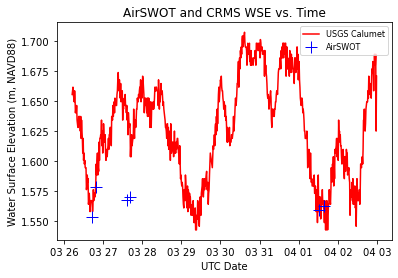

In [13]:
# Plot the CRMS time series and AirSWOT data.
plt.figure()
plt.plot(calumet_datetime, calumet_hgt, 'r-', label='USGS Calumet')
plt.plot(airswot_datetime, airswot_wse, 'b+', markersize=12, label='AirSWOT')
import matplotlib.dates as mdates
myFmt = mdates.DateFormatter('%m %d')
plt.gca().xaxis.set_major_formatter(myFmt)
plt.title('AirSWOT and CRMS WSE vs. Time')
plt.legend(loc='upper right', frameon=True, fontsize=8)
xlbl = plt.xlabel('UTC Date')
ylbl = plt.ylabel('Water Surface Elevation (m, NAVD88)')

The AirSWOT and USGS Calumet station data correspond fairly well, after the necessary vertical datum transformation has been applied (and after the AirSWOT data has been appropriately masked and filtered).

AirSWOT did have a small negative bias compared to the station data during the March 27 flight, but this bias is small (around 5 cm).  Previous efforts to validate AirSWOT data have resulted in AirSWOT root mean square error (RMSE) around 10 cm in most cases.  Therefore, the errors on the above plot are within the expected uncertainty of AirSWOT.

## Wrapping Up

In this module, we covered:

1. How to load in situ station data using Pandas, and compare the in situ data to water surface elevations estimated using AirSWOT.
2. How to use NOAA VDatum to calculate the vertical offset between different datums.
3. How to use GDAL Warp to convert AirSWOT height data from the WGS84 ellipsoid vertical datum to the NAVD88 geoid.

This concludes the AirSWOT portion of the Delta-X 2022 Applications Workshop.  We hope this has been interesting and helpful.  If you have questions or feedback on these modules, please feel free to contact Michael Denbina at: michael.w.denbina@jpl.nasa.gov.

Thanks for your attention!